# **Setting Up!**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install --upgrade gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
import re
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch
from collections import defaultdict
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
import multiprocessing
from time import time
from sklearn.metrics import accuracy_score

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# **Functions**

In [ ]:
def graph_length(column):
  length_list = [len(str(element)) for element in column]
  x = np.array(length_list)
  plt.figure(figsize=(10, 6))
  plt.plot(x)
  plt.title('Length vs SR NO')
  plt.xlabel('SR NO')
  plt.ylabel('Length')
  plt.show()

In [ ]:
def graph_histogram(column, x_min=None, x_max=None):
    length_list = [len(str(element)) for element in column]

    plt.figure(figsize=(10, 6))
    plt.hist(length_list, bins='auto', color='blue')

    if x_min is not None or x_max is not None:
      plt.xlim(left=x_min, right=x_max)
      plt.title('Frequency vs Length')
      plt.xlabel('Length')
      plt.ylabel('Frequenct')
      plt.grid(axis='y', alpha=0.75)
      plt.show()

In [ ]:
def percentage_exceeding_length(column, length_threshold):
    odd_text = [1 if len(str(element)) > length_threshold else 0 for element in column]
    num_of_elements = sum(odd_text)
    percentage = num_of_elements / len(column) * 100
    print(f'Number of texts above {length_threshold} contribute to {percentage}%')

In [ ]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

In [ ]:
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

In [ ]:
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [ ]:
def tokenization(text):
    tokens = re.split('\W+', text)
    return tokens

In [ ]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def cosine_simalarity(emb1,emb2):
  cos = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
  return cos

In [ ]:
def plot_embeddings_pca(embeddings, words):
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)

    plt.figure(figsize=(10, 10))
    for i in range(len(words)):
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
        plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], words[i])
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Word Embeddings Visualization using PCA')
    plt.grid(True)
    plt.show()

In [ ]:
def word_embedding_cobw(word):
  word_index = word_to_index[word]
  word_tensor = torch.tensor([word_index]).cuda()
  word_embedding = cbow_model.embeddings(word_tensor).detach().cpu().numpy().squeeze()  # Ensure the output is on CPU
  return word_embedding

In [ ]:
def concat_text_cbow(text):
  count = 0
  embedding = [0]*embed_size
  for word in text:
    word_embedding = word_embedding_cbow(word)
    embedding += word_embedding.squeeze()
    count+=1
  return embedding/count

In [ ]:
def concat_text_pretrained(text):
  embedding = [0]*300
  count = 0
  for words in text:
    if words in w2v_model.wv:
      word_embedding = w2v_model.wv[words]
      embedding += word_embedding.squeeze()
      count+=1
  return embedding/count

In [ ]:
def vectorize(sentence):
    words_vecs = [w2v_model.wv[word] for word in sentence if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(300)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)


# **Preliminary Preprocessing**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CS 419 - “I hated it. 8 10”/singapore_airlines_reviews.csv')

In [ ]:
df.head(2)

,published_date,published_platform,rating,type,text,title,helpful_votes
0,2024-03-12T14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0
1,2024-03-11T19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0


In [ ]:
#Checking null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   published_date      10000 non-null  object
 1   published_platform  10000 non-null  object
 2   rating              10000 non-null  int64 
 3   type                10000 non-null  object
 4   text                10000 non-null  object
 5   title               9999 non-null   object
 6   helpful_votes       10000 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 547.0+ KB


In [ ]:
df = df.dropna() #droping the rows having any null values

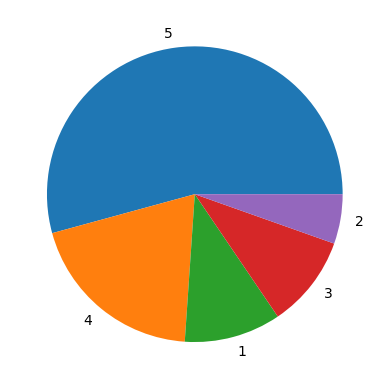

In [ ]:
#Number of reviews of each class
ratings = dict(df['rating'].value_counts())
plt.pie(ratings.values() ,labels = ratings.keys())
plt.show()

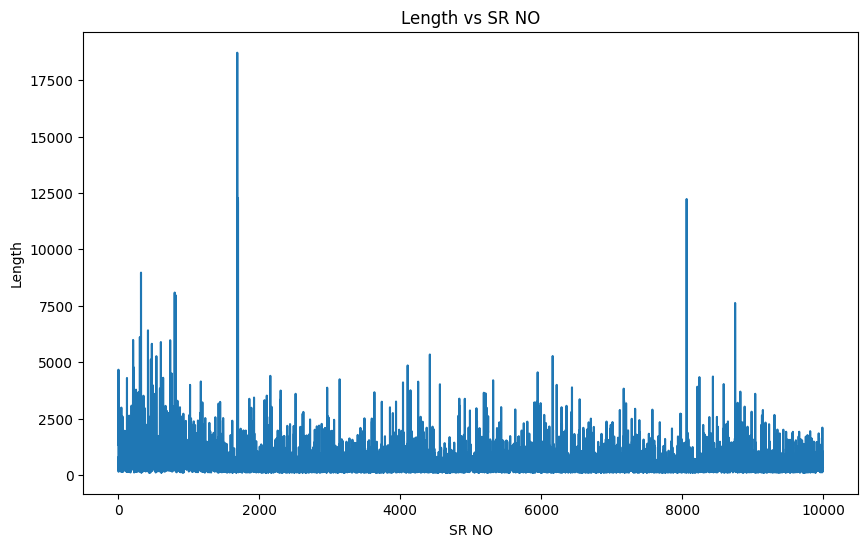

In [ ]:
#Length of text
graph_length(df['text'])

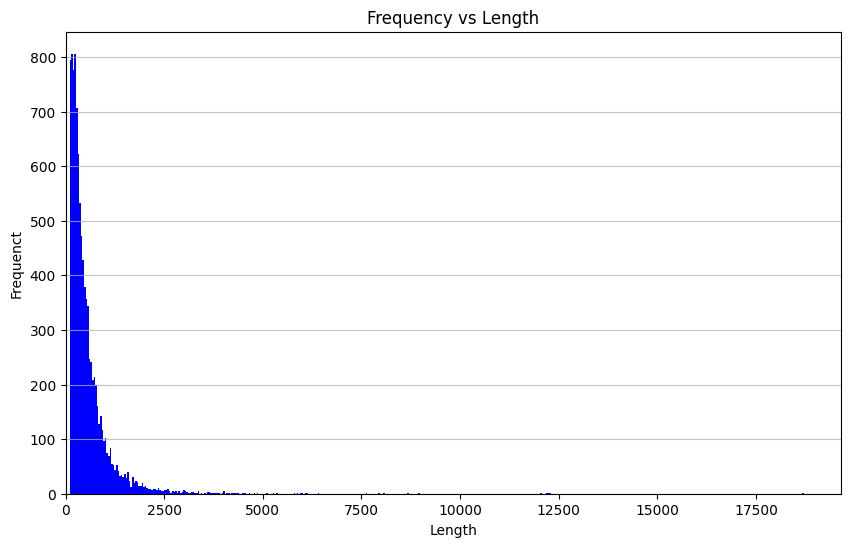

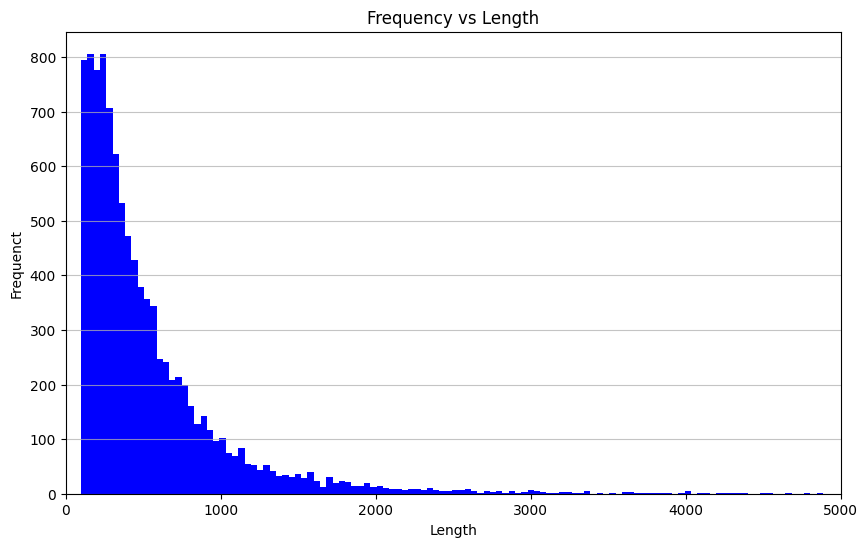

In [ ]:
#Histograms
graph_histogram(df['text'], x_min=0, x_max=None)
graph_histogram(df['text'], x_min=0, x_max=5000)

In [ ]:
percentage_exceeding_length(df['text'],1500)
percentage_exceeding_length(df['text'],2000)
percentage_exceeding_length(df['text'],2500)
percentage_exceeding_length(df['text'],5000)

Number of texts above 1500 contribute to 5.26052605260526%
Number of texts above 2000 contribute to 2.5302530253025304%
Number of texts above 2500 contribute to 1.5101510151015103%
Number of texts above 5000 contribute to 0.22002200220022%


In [ ]:
#Ignoring texts above 5000 length
df = df[df['text'].str.len() < 5000]

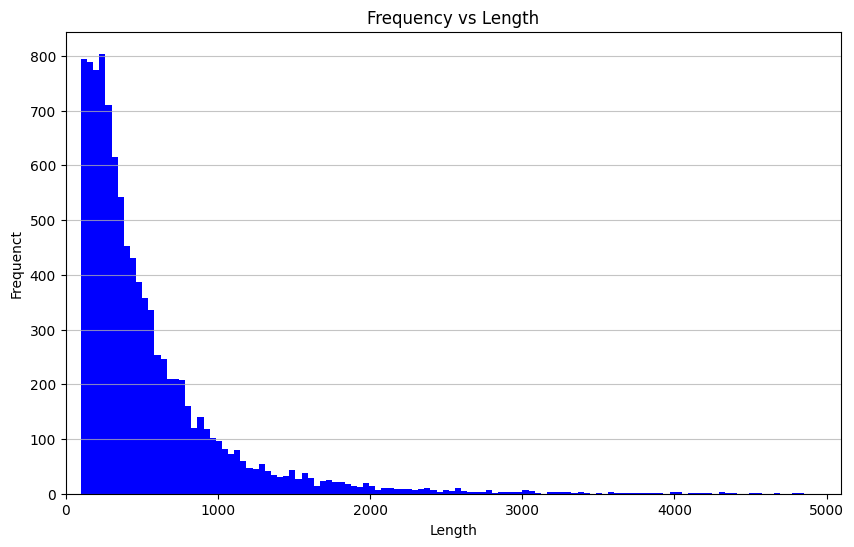

In [ ]:
graph_histogram(df['text'], x_min=0, x_max=None)

# **One Hot Encodings**

In [ ]:
df_ohe = df.copy()

In [ ]:
vocabulary = set()
for text in df['text']:
    for word in text:
        if word not in vocabulary:
            vocabulary.add(word)

In [ ]:
len(vocabulary)

588

In [ ]:
word_to_index = {word: i for i, word in enumerate(vocabulary)}

In [ ]:
one_hot_encoded=[]
def one_hot_encode(text):
    for word in text:
        one_hot_vector = [0] * len(vocabulary)
        one_hot_vector[word_to_index[word]] = 1
        one_hot_encoded.append(one_hot_vector)

In [ ]:
# df['one_hot_encodings'] = df['text'].apply(lambda x: one_hot_encode(x))

**Due to large size of Vocabulary one hot encodings cannot be implemented**

# **Bag of words**

In [ ]:
df_bow = df.copy()

In [ ]:
df_bow['text'] = df_bow['text'].apply(lambda x: remove_punctuation(x))
df_bow['text'] = df_bow['text'].apply(lambda x: x.lower())
df_bow['text'] = df_bow['text'].apply(remove_urls)
df_bow['text'] = df_bow['text'].apply(remove_html_tags)

In [ ]:
vectorizer = CountVectorizer(stop_words = 'english', max_features = 500)

In [ ]:
X = vectorizer.fit_transform(df_bow['text'])

In [ ]:
feature_names = vectorizer.get_feature_names_out()
print("Vocabulary (Feature Names):", feature_names)

Vocabulary (Feature Names): ['10' '12' '13' '15' '20' '30' '777' 'a350' 'a380' 'able' 'absolutely'
 'access' 'actually' 'agent' 'ago' 'air' 'airbus' 'aircraft' 'airline'
 'airlines' 'airport' 'aisle' 'amazing' 'amenities' 'area' 'arrival'
 'arrived' 'asia' 'ask' 'asked' 'asking' 'assistance' 'attendant'
 'attendants' 'attention' 'attentive' 'australia' 'available' 'average'
 'away' 'bad' 'bag' 'baggage' 'bags' 'bali' 'bangkok' 'bed' 'believe'
 'best' 'better' 'big' 'bit' 'board' 'boarded' 'boarding' 'boeing' 'book'
 'booked' 'booking' 'breakfast' 'brisbane' 'budget' 'business' 'cabin'
 'called' 'came' 'cancelled' 'care' 'carrier' 'case' 'certainly'
 'champagne' 'change' 'changed' 'changi' 'charge' 'check' 'checked'
 'checkin' 'checking' 'chicken' 'children' 'choice' 'choices' 'choose'
 'chose' 'class' 'clean' 'cold' 'come' 'comfort' 'comfortable' 'comfy'
 'coming' 'company' 'compared' 'complaint' 'configuration' 'connecting'
 'connection' 'contact' 'cook' 'cost' 'counter' 'couple' 'cou

In [ ]:
X = X.toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, df_bow['rating'], test_size = 0.20, random_state = 0)

In [ ]:
bow = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)

In [ ]:
bow.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=0)

In [ ]:
y_pred = bow.predict(X_test)

In [ ]:
count = np.sum(y_pred == y_test)
accuracy = count / len(y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.6277555110220441


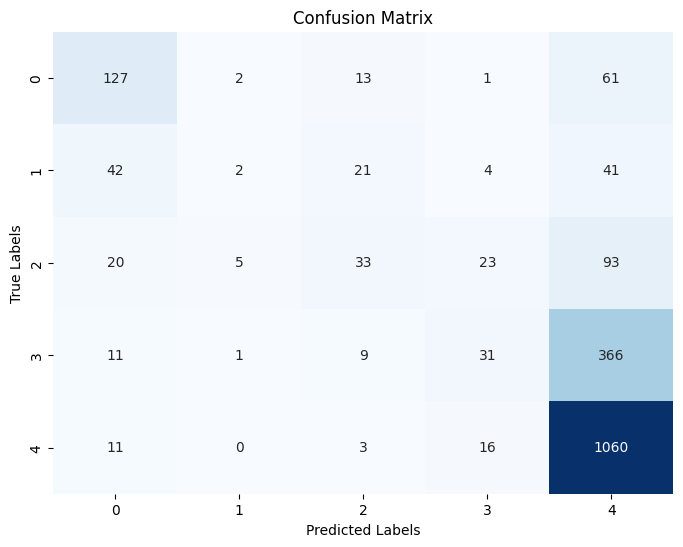

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# **CBOW - Training our own word embedings**

In [ ]:
df_cbow = df.copy()

In [ ]:
df_cbow['text'] = df_cbow['text'].apply(lambda x: remove_punctuation(x))
df_cbow['text'] = df_cbow['text'].apply(lambda x: x.lower())
df_cbow['text'] = df_cbow['text'].apply(remove_urls)
df_cbow['text'] = df_cbow['text'].apply(remove_html_tags)
df_cbow['text'] = df_cbow['text'].apply(lambda x: tokenization(x))
df_cbow['text'] = df_cbow['text'].apply(lambda x:remove_stopwords(x))
df_cbow['text'] = df_cbow['text'].apply(lambda x:lemmatizer(x))

In [ ]:
df_cbow.head(2)

,published_date,published_platform,rating,type,text,title,helpful_votes
0,2024-03-12T14:41:14-04:00,Desktop,3,review,"[used, airline, go, singapore, london, heathro...",Ok,0
1,2024-03-11T19:39:13-04:00,Desktop,5,review,"[service, singapore, airline, suite, class, no...",The service in Suites Class makes one feel lik...,0


In [ ]:
class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(CBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_size)
        self.linear1 = nn.Linear(embed_size, 128)
        self.linear2 = nn.Linear(128, vocab_size)
        self.activation_function = nn.LogSoftmax(dim=-1)

    def forward(self, context):
        context_embeds = sum(self.embeddings(context)).view(1, -1)
        out = self.linear1(context_embeds)
        out = self.linear2(out)
        out = self.activation_function(out)
        return out

In [ ]:
context_size = 2
vocabulary = set()
for text in df_cbow['text']:
    for word in text:
        if word not in vocabulary:
            vocabulary.add(word)
word_to_index = {word: i for i, word in enumerate(vocabulary)}
index_to_word = {i: word for i, word in enumerate(vocabulary)}
data = []
for tokens in df_cbow['text']:
	for i in range(2, len(tokens) - 2):
		context = [word_to_index[word] for word in tokens[i - 2:i] + tokens[i + 1:i + 3]]
		target = word_to_index[tokens[i]]
		data.append((torch.tensor(context), torch.tensor(target)))

In [ ]:
# Hyperparameters
vocab_size = len(vocabulary)
embed_size = 100
learning_rate = 0.001
epochs = 25
batch_size = 256

# Initialize CBOW model
cbow_model = CBOWModel(vocab_size, embed_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cbow_model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, (contexts, targets) in enumerate(data):
        optimizer.zero_grad()

        # Move data to the appropriate device
        contexts = contexts.to(device)
        targets = targets.to(device)

        output = cbow_model(contexts)
        loss = criterion(output, targets.unsqueeze(0))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if (batch_idx + 1) % 10000 == 0:
            print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}, Loss: {loss.item()}")

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(data)}")


Epoch 1, Batch 1000, Loss: 8.63587474822998
Epoch 1, Batch 2000, Loss: 8.118627548217773
Epoch 1, Batch 3000, Loss: 11.876601219177246
Epoch 1, Batch 4000, Loss: 10.237709045410156
Epoch 1, Batch 5000, Loss: 9.55483627319336
Epoch 1, Batch 6000, Loss: 2.613602876663208
Epoch 1, Batch 7000, Loss: 6.475751876831055
Epoch 1, Batch 8000, Loss: 11.53237533569336
Epoch 1, Batch 9000, Loss: 3.4748363494873047
Epoch 1, Batch 10000, Loss: 9.047563552856445
Epoch 1, Batch 11000, Loss: 7.5151262283325195
Epoch 1, Batch 12000, Loss: 5.2862653732299805
Epoch 1, Batch 13000, Loss: 9.505168914794922
Epoch 1, Batch 14000, Loss: 8.117530822753906
Epoch 1, Batch 15000, Loss: 6.780863285064697
Epoch 1, Batch 16000, Loss: 14.815566062927246
Epoch 1, Batch 17000, Loss: 6.112725257873535
Epoch 1, Batch 18000, Loss: 9.424160957336426
Epoch 1, Batch 19000, Loss: 8.164518356323242
Epoch 1, Batch 20000, Loss: 4.694113731384277
Epoch 1, Batch 21000, Loss: 1.7267857789993286
Epoch 1, Batch 22000, Loss: 3.40567064

KeyboardInterrupt: 

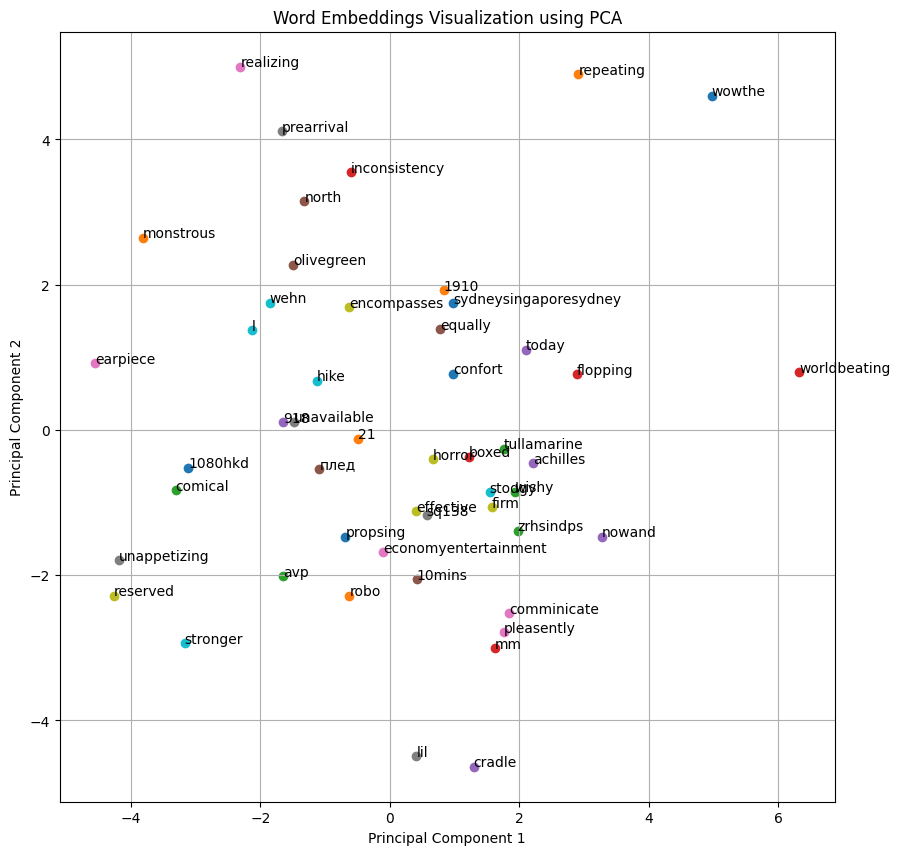

In [ ]:
random_words = np.random.choice(list(vocabulary), size=50, replace=False)
word_embeddings = []
selected_words = []


for word in random_words:
    word_index = word_to_index[word]
    word_tensor = torch.tensor([word_index]).cuda()
    word_embedding = cbow_model.embeddings(word_tensor).detach().cpu().numpy().squeeze()
    word_embeddings.append(word_embedding)
    selected_words.append(word)


word_embeddings = np.array(word_embeddings)

plot_embeddings_pca(word_embeddings, selected_words)

In [ ]:
#Word embedding of word good
good = word_embedding_cobw('good')
bad = word_embedding_cobw('bad')
sim = cosine_simalarity(good,bad)
print(sim)

0.09756796


In [ ]:
df_cbow['embeddings'] = df_cbow['text'].apply(concat_text_cbow)

In [ ]:
X = np.array([np.hstack(embedding) for embedding in df_cbow['embeddings']])
X_train,X_test,y_train,y_test = train_test_split(X,
                                                df_cbow['rating'],
                                                test_size=0.2,
                                                random_state=0)

In [ ]:
cbow = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)

In [ ]:
cbow.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=0)

In [ ]:
y_pred = cbow.predict(X_test)
count = np.sum(y_pred == y_test)
accuracy = count / len(y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.5350701402805611


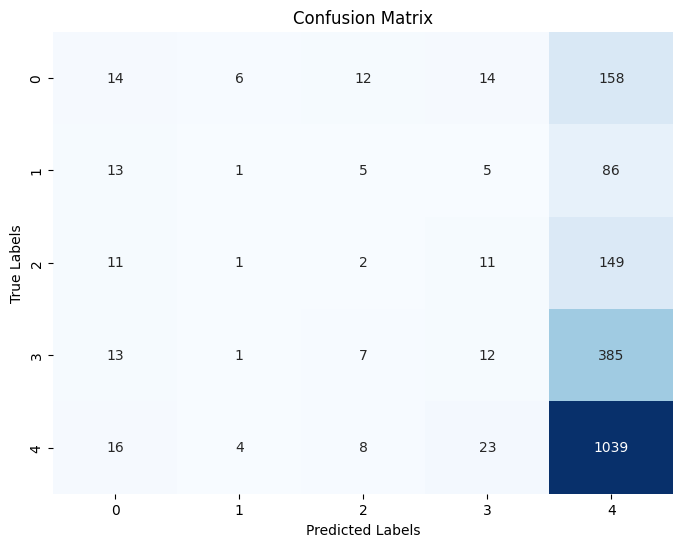

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# **Pretrained Word-Embedding**

In [ ]:
#https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial

In [ ]:
df_w2v = df.copy()

In [ ]:
df_w2v['text'] = df_w2v['text'].apply(lambda x: remove_punctuation(x))
df_w2v['text'] = df_w2v['text'].apply(lambda x: x.lower())
df_w2v['text'] = df_w2v['text'].apply(remove_urls)
df_w2v['text'] = df_w2v['text'].apply(remove_html_tags)
df_w2v['text'] = df_w2v['text'].apply(lambda x: tokenization(x))
df_w2v['text'] = df_w2v['text'].apply(lambda x:remove_stopwords(x))
df_w2v['text'] = df_w2v['text'].apply(lambda x:lemmatizer(x))

In [ ]:
df_w2v['title'] = df_w2v['title'].apply(lambda x: x.lower())
df_w2v['title'] = df_w2v['title'].apply(lambda x: remove_punctuation(x))
df_w2v['title'] = df_w2v['title'].apply(remove_urls)
df_w2v['title'] = df_w2v['title'].apply(remove_html_tags)
df_w2v['title'] = df_w2v['title'].apply(lambda x: tokenization(x))
df_w2v['title'] = df_w2v['title'].apply(lambda x:remove_stopwords(x))
df_w2v['title'] = df_w2v['title'].apply(lambda x:lemmatizer(x))

In [ ]:
df_w2v['combined'] = df_w2v['title'] + df_w2v['text']

In [ ]:
df_w2v.head(2)

,published_date,published_platform,rating,type,text,title,helpful_votes,combined
0,2024-03-12T14:41:14-04:00,Desktop,3,review,"[used, airline, go, singapore, london, heathro...",[ok],0,"[ok, used, airline, go, singapore, london, hea..."
1,2024-03-11T19:39:13-04:00,Desktop,5,review,"[service, singapore, airline, suite, class, no...","[service, suite, class, make, one, feel, like,...",0,"[service, suite, class, make, one, feel, like,..."


In [ ]:
phrases = Phrases(df_w2v['combined'], min_count=30, progress_per=10000)

In [ ]:
bigram = Phraser(phrases)

In [ ]:
sentences = bigram[df_w2v['combined']]

In [ ]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

21781

In [ ]:
cores = multiprocessing.cpu_count()

In [ ]:
w2v_model = Word2Vec(min_count=20,
                     window=5,
                     vector_size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers = cores-1)

In [ ]:
t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.01 mins


In [ ]:
t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 3.72 mins


In [ ]:
w2v_model.init_sims(replace=True)

<ipython-input-176-c7757d71a30b>:1: DeprecationWarning:

Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).



In [ ]:
w2v_model.wv.most_similar(positive=["good"])

[('great', 0.6833053827285767),
 ('excellent', 0.6468510031700134),
 ('food', 0.6437519788742065),
 ('comfortable', 0.6165361404418945),
 ('entertainment', 0.6101332306861877),
 ('nice', 0.5774825215339661),
 ('tasty', 0.5122053027153015),
 ('selection', 0.5026015639305115),
 ('spacious', 0.4886651039123535),
 ('attentive', 0.48715317249298096)]

In [ ]:
w2v_model.wv.similarity("good", 'bad')

0.014820202

In [ ]:
df_w2v['embeddings'] = df_w2v['combined'].apply(concat_text_pretrained)

In [ ]:
df_w2v.head(2)

,published_date,published_platform,rating,type,text,title,helpful_votes,combined,embeddings
0,2024-03-12T14:41:14-04:00,Desktop,3,review,"[used, airline, go, singapore, london, heathro...",[ok],0,"[ok, used, airline, go, singapore, london, hea...","[0.010208006674208894, 0.0014020178243159675, ..."
1,2024-03-11T19:39:13-04:00,Desktop,5,review,"[service, singapore, airline, suite, class, no...","[service, suite, class, make, one, feel, like,...",0,"[service, suite, class, make, one, feel, like,...","[0.004627325069666554, 0.005496457290968841, -..."


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(df_w2v['embeddings'].tolist())


df_3d = pd.DataFrame(embeddings_3d, columns=['PCA1', 'PCA2', 'PCA3'])
df_3d['rating'] = df_w2v['rating']


fig = px.scatter_3d(df_3d, x='PCA1', y='PCA2', z='PCA3', color='rating', symbol='rating', opacity=0.7, width=800, height=600)
fig.update_layout(title='3D Embeddings with PCA', scene=dict(xaxis_title='Principal Component 1', yaxis_title='Principal Component 2', zaxis_title='Principal Component 3'))
fig.show()


# **SVM**

In [ ]:
from sklearn import svm

In [ ]:
x = np.array([np.hstack(embedding) for embedding in df_w2v['embeddings']])
X_train,X_test,y_train,y_test = train_test_split(x,
                                                df_w2v['rating'],
                                                test_size=0.2,
                                                random_state=0)

In [ ]:
clf_RBF = svm.SVC(kernel='rbf')
clf_RBF.fit(X_train, y_train)

SVC()

In [ ]:
y_pred = clf_RBF.predict(X_test)
count = np.sum(y_pred == y_test)
accuracy = count / len(y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.6978957915831663


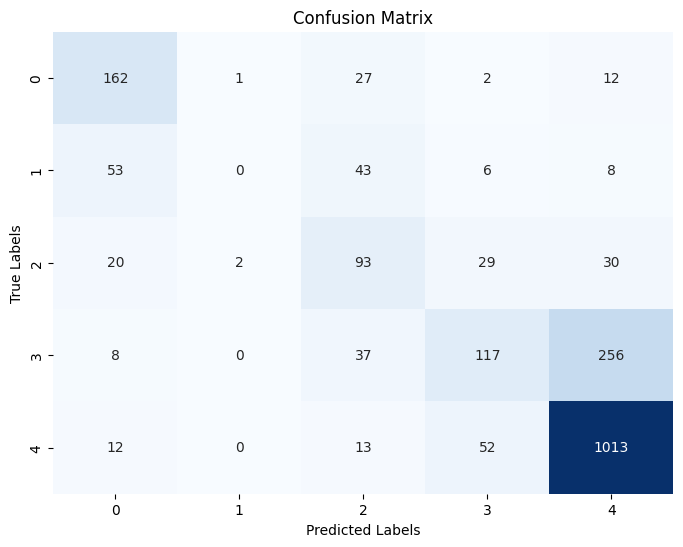

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# **XGBOOST**

In [ ]:
x = np.array([np.hstack(embedding) for embedding in df_w2v['embeddings']])
X_train,X_test,y_train,y_test = train_test_split(x,
                                                df_w2v['rating'],
                                                test_size=0.2,
                                                random_state=0)

In [ ]:
w2v = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)

In [ ]:
w2v.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=0)

In [ ]:
y_pred = w2v.predict(X_test)
count = np.sum(y_pred == y_test)
accuracy = count / len(y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.6533066132264529


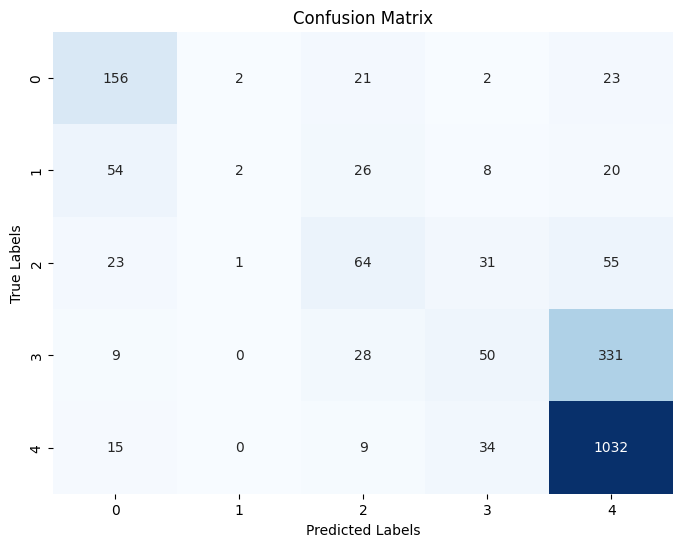

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# **NN Model**

In [ ]:
df_w2v.head(2)

,published_date,published_platform,rating,type,text,title,helpful_votes,combined,embeddings
0,2024-03-12T14:41:14-04:00,Desktop,3,review,"[used, airline, go, singapore, london, heathro...",[ok],0,"[ok, used, airline, go, singapore, london, hea...","[0.010208006674208894, 0.0014020178243159675, ..."
1,2024-03-11T19:39:13-04:00,Desktop,5,review,"[service, singapore, airline, suite, class, no...","[service, suite, class, make, one, feel, like,...",0,"[service, suite, class, make, one, feel, like,...","[0.004627325069666554, 0.005496457290968841, -..."


In [ ]:
df_w2v['rating'] = df_w2v['rating'] - 1

In [ ]:
df_w2v.head(2)

,published_date,published_platform,rating,type,text,title,helpful_votes,combined,embeddings
0,2024-03-12T14:41:14-04:00,Desktop,2,review,"[used, airline, go, singapore, london, heathro...",[ok],0,"[ok, used, airline, go, singapore, london, hea...","[0.010208006674208894, 0.0014020178243159675, ..."
1,2024-03-11T19:39:13-04:00,Desktop,4,review,"[service, singapore, airline, suite, class, no...","[service, suite, class, make, one, feel, like,...",0,"[service, suite, class, make, one, feel, like,...","[0.004627325069666554, 0.005496457290968841, -..."


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_w2v['combined'], df_w2v['rating'], test_size=0.2, random_state=42)
X_train = np.array([vectorize(sentence) for sentence in X_train])
X_test = np.array([vectorize(sentence) for sentence in X_test])

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(300, 32)
        # self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(32, 5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = SimpleNN().to(device)

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
# y_train = y_train.to_numpy()
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

# Create TensorDataset and DataLoader
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
# y_test = y_test.to_numpy()
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create TensorDataset and DataLoader
dataset_test = TensorDataset(X_test_tensor, y_test_tensor)
dataloader_tests = DataLoader(dataset_test, batch_size=128, shuffle=True)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete.")


Epoch [1/50], Loss: 1.3735
Epoch [2/50], Loss: 1.1342
Epoch [3/50], Loss: 1.0078
Epoch [4/50], Loss: 0.9919
Epoch [5/50], Loss: 0.6992
Epoch [6/50], Loss: 1.0101
Epoch [7/50], Loss: 0.8127
Epoch [8/50], Loss: 0.9110
Epoch [9/50], Loss: 0.8211
Epoch [10/50], Loss: 0.7724
Epoch [11/50], Loss: 0.9274
Epoch [12/50], Loss: 0.7869
Epoch [13/50], Loss: 0.9628
Epoch [14/50], Loss: 0.6336
Epoch [15/50], Loss: 0.7345
Epoch [16/50], Loss: 0.6842
Epoch [17/50], Loss: 0.8881
Epoch [18/50], Loss: 0.7347
Epoch [19/50], Loss: 0.9236
Epoch [20/50], Loss: 0.6934
Epoch [21/50], Loss: 0.7470
Epoch [22/50], Loss: 0.8637
Epoch [23/50], Loss: 0.6487
Epoch [24/50], Loss: 0.8926
Epoch [25/50], Loss: 0.6581
Epoch [26/50], Loss: 0.5437
Epoch [27/50], Loss: 0.7169
Epoch [28/50], Loss: 0.7465
Epoch [29/50], Loss: 0.7433
Epoch [30/50], Loss: 0.8122
Epoch [31/50], Loss: 0.7449
Epoch [32/50], Loss: 0.6110
Epoch [33/50], Loss: 0.6796
Epoch [34/50], Loss: 0.8051
Epoch [35/50], Loss: 0.6445
Epoch [36/50], Loss: 0.6934
E

In [ ]:
# Evaluation phase
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in dataloader_tests:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(accuracy)

0.7019038076152304


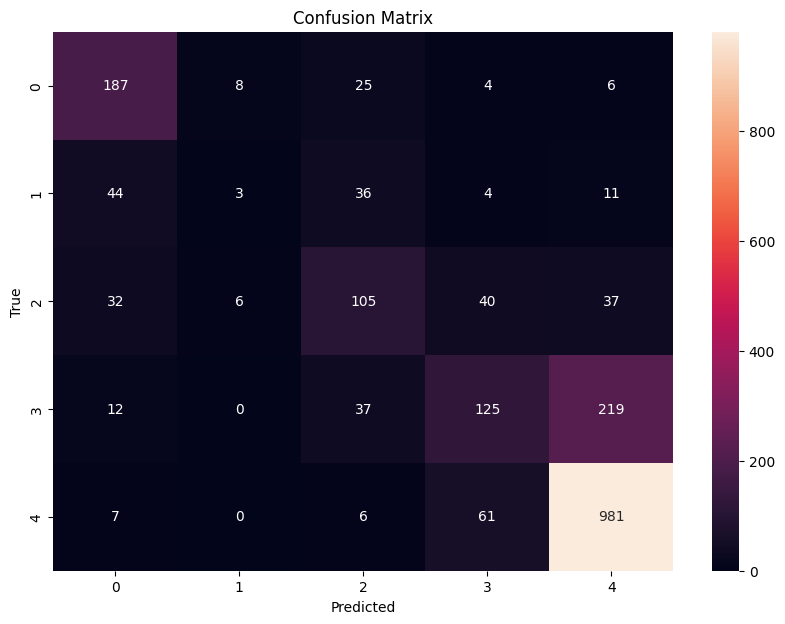

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()